In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *

# datatype definitions
ndarray = np.ndarray

In [2]:
#====================================================================
# Stores the order and variables for a Legendre Polynomial and uses
# rk4 to integrate along the polynomials using the Legendre
# differential equation
#====================================================================
class Legendre:
    
    def __init__(self, n : int):
        """
        Parameters:
            n - order of the polynomial
        """
        
        self.n = n
        self.x = 0
        self.y = 0
        self.y_prime = 0
    
    #Private:
    def __vectorize(self) -> ndarray:
        """
        Puts all of the Legendre object's variable data into a nicely formatted vector
        """        
        return np.array([self.y, self.y_prime])
    
    def __unvectorize(self, vector : ndarray) -> None:
        """
        Takes a nicely formatted vector and sets all of the Binary's data to the values
        Basically the inverse of __vectorize
        """           
        self.y = vector[0]
        self.y_prime = vector[1]
    
    def __offsetDifferential(self, offset : float | ndarray) -> ndarray:
        """
        Takes the vectorized data and applies an offset 
        Returns the derivative of each offset datum
        """ 
        # offset data
        offset_vector = self.__vectorize() + offset
        
        n = self.n
        x = self.x
        y = offset_vector[0]
        y_1 = offset_vector[1]
        
        # Legendre equation
        y_2 = 1 / (1 - x*x) * (2*x*y_1 - n*(n + 1)*y)
        
        differential = np.concatenate((y_1, y_2), axis=None)
        
        return differential
    
    def __rk4(self, dt : float):
        """
        Takes a time step over which to compute the Runge-Kutta method
        Returns a vector of the Legendre objects's data after the 
        provided time step
        """
        
        if dt < 0:
            raise ValueError("step size must be positive")
        
        k1 = self.__offsetDifferential(0) * dt
        k2 = self.__offsetDifferential(0.5*k1) * dt
        k3 = self.__offsetDifferential(0.5*k2) * dt
        k4 = self.__offsetDifferential(k3) * dt
        
        self.x += dt
        
        return self.__vectorize() + (k1 + 2*k2 + 2*k3 + k4)/6
    
    #public:
    def shoot(self, dt : float, target_x : float, init_x : float, init_y : float, init_y_prime : float) -> float:
        """
        Steps from initial x to target x using the rk4 method and returns the
        array of x and y values computed along the way.
        Parameters:
            dt -           integration step size
            target_x -     x which we want to integrate until
            init_x -       initial value for x
            init_y -       initial value for y
            init_y_prime - initial value for the first derivative of y
        """
        # Initialize
        self.x = init_x
        self.y = init_y
        self.y_prime = init_y_prime
        
        X = []
        Y = []
        
        # Loop until target x is reached
        while self.x < target_x:
            if self.x + dt > target_x:
                dt = 1 - self.x
            
            #Take one step up rk4
            self.__unvectorize(self.__rk4(dt))
            
            X.append(self.x)
            Y.append(self.y)
        
        # Reset to initial conditions
        self.x = 0
        self.y = 0
        self.y_prime = 0
        
        return X, Y

In [3]:
L = Legendre(5)

# Returns true if x and y have the same sign.
def sign(x, y):
    return (x > 0 and y > 0) or (x < 0 and y < 0)

#====================================================================
# Parameters:
# - f       : a function we wish to find the roots of
# - xmin    : minimum x  of the interval we wish to search
# - xmax    : maximum x  of the interval we wish to search
# - eps     : desired precision
# - maxIter : maximum number of times the search will loop
# Returns:
#  A value x for which f(x) == 0
#====================================================================
def bisection(f, xmin, xmax, eps, maxIter = 1000):
    
    fmin = f(xmin)
    fmax = f(xmax)
    
    if fmin == 0:
        return xmin
    if fmax == 0:
        return xmax
    
    if sign(fmin, fmax):
        raise ValueError("f(xmin) and f(xmax) have the same sign; there is no guarentee of a root between them")
    
    for i in range(maxIter):
        
        # Find the midpoint value
        x = (xmin + xmax) / 2
        value = f(x)
        
        # Determine if we need more refinement
        if abs(value) < eps:
            break
        elif sign(value, fmin):
            xmin = x
            fmin = value
        else:
            xmax = x
            fmax = value
    else:
        # If the loop doesn't break, we failed to converge in the maximum number of steps
        print("Failed to converge in {} steps".format(maxIter))
    
    return x


x0 = 0
y0 = 0
y_min = -1
y_max = 3
dt = 1e-4
eps = 1e-8

# We want to find the value of y_prime which makes P(1) = 1
f = lambda y_: L.shoot(dt, 1, x0, y0, y_)[1][-1] - 1
y_1 = bisection(f, y_min, y_max, eps)

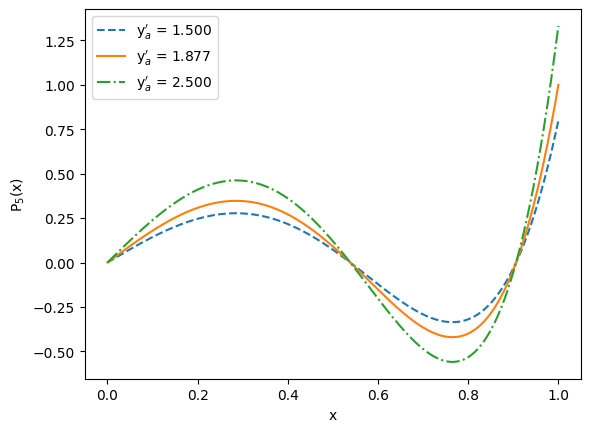

In [7]:
# Plotting
X0, Y0 = L.shoot(dt, 1, x0, y0, 1.5)
X1, Y1 = L.shoot(dt, 1, x0, y0, y_1)
X2, Y2 = L.shoot(dt, 1, x0, y0, 2.5)
plt.plot(X0, Y0, "--", label=r"y$_a'$ = 1.500")
plt.plot(X1, Y1, label=r"y$_a'$ = {}".format(round(y_1, 3)))
plt.plot(X2, Y2, "-.", label=r"y$_a'$ = 2.500")
plt.xlabel("x")
plt.ylabel(r"P$_5$(x)")
plt.legend()
plt.show()